In [883]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import shap
from IPython.display import display

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting

import dtreeviz
import graphviz


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [884]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [885]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')

In [886]:
df_bb.columns
df_bb.shape
df_fb.shape


(1263, 24)

In [887]:
df_fb.columns

Index(['Unnamed: 0', 'NAME', 'GRADE', 'AGE', 'SKILL', 'STARCOLL', 'NUMOFF',
       'POS', 'HEIGHT_IN', 'WEIGHT_LBS', 'COLLDIST_MI', 'NILVAL_LONG_USD',
       'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'TOT_FOL', 'SPORT',
       'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS', 'institution_name_short',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [888]:
#save athlete names for later indexing
athletes_fb = df_fb['NAME']
athletes_bb = df_bb['NAME']
# athlete_names

df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','EXP_YEARS','institution_name_short'])
df_fb= df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])


In [889]:
# df_bb.head()
df_bb.shape


(137, 18)

In [890]:
#Descriptive statistics of the target variable


def format_dollars(x):
    return f'{x:.2f}'
   
# Set the formatting function for float values
pd.options.display.float_format = format_dollars

# Assuming df_bb is your DataFrame
summary = df_bb['NILVAL_LONG_USD'].describe()
print(summary)

count       137.00
mean     266379.56
std      539449.37
min       60000.00
25%       90000.00
50%      145000.00
75%      288000.00
max     6100000.00
Name: NILVAL_LONG_USD, dtype: float64


In [891]:
#Mode value
df_bb.NILVAL_LONG_USD.mode()

0   108000.00
dtype: float64

Mean ($266,379.56) is greater than  median ($145,000.00), and the 75th percentile ($288,000.00) is substantially greater than the 25th percentile ($90,000.00). This indicates that the data is positively skewed, with a longer tail on the right side of the distribution.

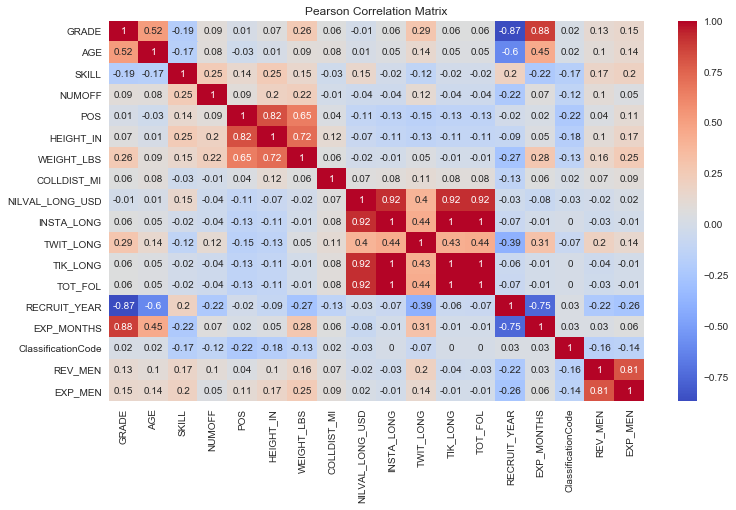

In [892]:
#Pearson Correlation matrix
plt.figure(figsize=(12,7))
plt.title('Pearson Correlation Matrix')
sns.heatmap(df_bb.corr().round(2),annot=True, cmap = 'coolwarm')

**Feature Selection and Engineering**

Looking like there is some high correlation with Recruit year and other features (GRADE, EXP MONTHS) and TOT_FOL with othe social media counts

In [893]:
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [894]:
df_bb=df_bb.copy()
df_bb=df_bb.drop(columns=['RECRUIT_YEAR','TOT_FOL'])
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [895]:
#categorical variables = GRADE, POS, CLASSIFICATIONCODE
# Select the categorical columns
categorical_subset = df_bb[['GRADE','POS','ClassificationCode']]
# one hot encode
categorical_subset = pd.get_dummies(categorical_subset)
# categorical_subset

In [896]:
#natural log transformation
#If the negative or zero values are not outliers - log1p has warning so trying small constant for social media data

df_num = df_bb.copy()
# Specify the numeric columns to log-transform
numeric_columns = ['AGE', 'SKILL', 'NUMOFF', 'HEIGHT_IN', 'WEIGHT_LBS',
                   'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG',
                   'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS', 'REV_MEN', 'EXP_MEN']

# Apply log transformation to selected numeric columns
small_constant = 3  # Adjust as needed
for column in numeric_columns:
    df_num[column] = np.log(df_num[column] + small_constant)


df_bb2 = result = pd.concat([df_num, categorical_subset], axis=1)
df_bb2.head(2)
# df_bb2.shape #(137, 19)

,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN,GRADE,POS,ClassificationCode
0,2.00,3.04,4.63,3.00,1.00,4.36,5.26,7.56,13.29,7.94,7.94,1.10,1.61,1.00,15.80,16.07,2.00,1.00,1.00
1,2.00,3.04,4.61,2.77,1.00,4.36,5.26,7.62,15.62,15.58,10.09,15.57,1.61,1.00,15.80,16.07,2.00,1.00,1.00


In [897]:
# df_bb.columns

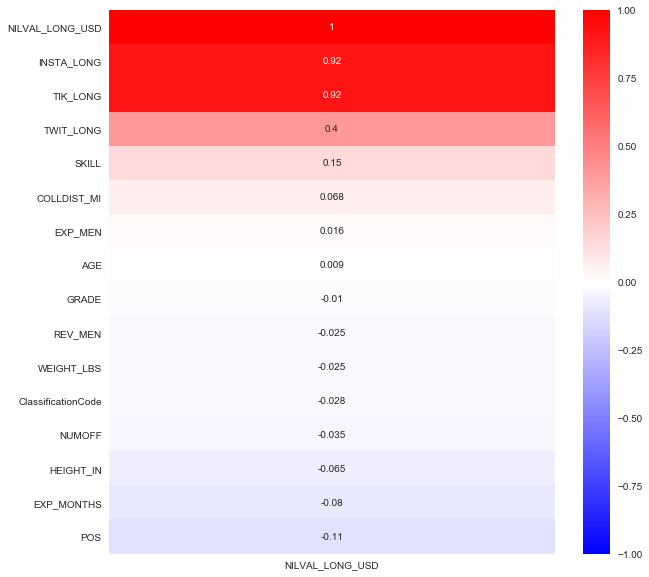

In [898]:
#Correlation heatmap
#https://stackoverflow.com/questions/72213733/how-to-plot-seaborn-heatmap-for-target-vs-independent-features
#+1= highly and positively correlated and -1 = highly negatively correlated.
def corr_plot(df):
    corr_matrix = df.corr()
    data=pd.DataFrame(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False))  #plotting all but could do top (>.50)
    plt.figure(figsize = (10,10))
    return  sns.heatmap(data, annot=True, vmin=-1, vmax=1, cmap='bwr')
    # ax.tick_params(labelrotation=0)

corr_plot(df_bb)

In [899]:
# #outliers check
# def outl(x):
#     plt.figure(figsize=(10,5))
#     plt.subplot(121)
#     plt.boxplot(df_bb[x])
#     plt.subplot(122)
#     sns.distplot(df_bb[x])
#     plt.tight_layout()
#     plt.show()

In [900]:
# for col in df_bb2.columns:
#     outl(col)

Do outlier treatment for TIK_LONG, TWIt_LONG, INSTA_LONG, COLL_DIST

In [901]:
# df_bb.columns

In [902]:
# columns = ['COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',]

# # Create a dictionary to store the descriptions
# descriptions = {}

# for col in columns:
#     descriptions[col] = df_bb[col].describe()

# # Display the descriptions for each column
# for col, description in descriptions.items():
#     print(f"Summary statistics for {col}:")
#     print(description)
#     print()

In [903]:
# #using iqr method, considering both including and excluding the lower and upper limits into two separate dataframes, 
# # then merging both the dataframes into one.
# #goal is to filter the data to remove or cap extreme values, and then merge the resulting data back together
# q1 = df_bb['INSTA_LONG'].quantile(0.25)
# q2 = df_bb['INSTA_LONG'].quantile(0.50)
# q3 = df_bb['INSTA_LONG'].quantile(0.75)
# IQR = q3-q1

# lower_limit = q1-1.5*IQR
# upper_limit = q3+1.5*IQR

# data_inc = df_bb.loc[(df_fb['INSTA_LONG']>=lower_limit) & (df_bb['INSTA_LONG']<=upper_limit)]
# data_esc = df_bb.loc[(df_fb['INSTA_LONG']>lower_limit) & (df_bb['INSTA_LONG']<upper_limit)]
# df_bb2 = pd.concat([data_inc,data_esc])
# df_bb2.head()

In [904]:
# for col in df_bb2.columns:
#     outl(col)

In [905]:
# df_bb2['INSTA_LONG'].describe
# df_bb2.shape #(137, 32)
# df_bb2.dtypes

**NAIVE BASELINE**

In [906]:

ind =['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN']
features = df_bb2[ind]
dep= [ 'NILVAL_LONG_USD']
target = df_bb2[dep]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the MAE function
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate the baseline prediction
baseline_guess = np.median(y_train)

# Evaluate the baseline prediction on the test data
y_baseline_pred = np.full_like(y_test, baseline_guess)
baseline_mae = mae(y_test, y_baseline_pred)

dict = { 'Target': dep, 
        'Naive Baseline': 'Basketball',
        'Baseline MAE': baseline_mae}
base = pd.DataFrame(dict)
print("Baseline MAE:", baseline_mae)
display(base)


Baseline MAE: NILVAL_LONG_USD   0.55
dtype: float64


,Target,Naive Baseline,Baseline MAE
NILVAL_LONG_USD,NILVAL_LONG_USD,Basketball,0.55


**Linear Regression**

In [907]:
train_bb, test_bb = train_test_split(df_bb2, test_size=0.20, shuffle=True, random_state=42)
print('Shape for train_bb is {0}, df_test is {1}'.format(train_bb.shape,test_bb.shape))

Shape for train_bb is (109, 19), df_test is (28, 19)


In [908]:
# train_bb
# test_bb

y_trainbb = train_bb['NILVAL_LONG_USD']
X_trainbb = train_bb.drop('NILVAL_LONG_USD',axis=1)
y_testbb= test_bb['NILVAL_LONG_USD']
X_testbb = test_bb.drop('NILVAL_LONG_USD',axis=1)

# y_testbb

**Linear Regression - All Features**

In [909]:
#Get metrics
'''1 - r2 is the reduction in unexplained variance due to the model.
(n - 1) is the total degrees of freedom in the data.
(n - p - 1) is the degrees of freedom adjusted for the number of predictors used in the model.'''

#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [910]:
lr = LinearRegression()

lr.fit(X_trainbb, y_trainbb)
y_pred_trainbb_lr = lr.predict(X_trainbb)
y_pred_testbb_lr = lr.predict(X_testbb)

r2_train = r2_score(y_trainbb, y_pred_trainbb_lr)
# adj_r2_train = adjusted_r2_score(X_trainbb, y_trainbb, y_pred_trainbb_lr)
rmse_train = rmse(y_trainbb, y_pred_trainbb_lr)
mae_train = mae(y_trainbb, y_pred_trainbb_lr)
r2_test= r2_score(y_testbb, y_pred_testbb_lr)
# adj_r2_test = adjusted_r2_score(X_testbb, y_testbb, y_pred_testbb_lr)
rmse_test = rmse(y_testbb, y_pred_testbb_lr)
mae_test = mae(y_testbb, y_pred_testbb_lr)

print('R2 score of train data is ', r2_train)
print('rmse score of train data is ', rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('rmse score of test data is ', rmse_test)
print('mae score of test data is ', mae_test)

R2 score of train data is  0.4174940790716629
rmse score of train data is  0.6150710078886601
mae score of train data is  0.46913311260542573

R2 score of test data is  0.1069619598130992
rmse score of test data is  0.6141586637283212
mae score of test data is  0.5223261220571783


In [911]:
results = pd.DataFrame(columns = ['Algorithm',
                                  'Train_R2 score',
                                  'Train_Adj_R2 score',
                                  'Train_RMSE score',
                                  'Train_MAE score',
                                  'Test_R2 score',
                                  'Test_Adj_R2 score',
                                  'Test_RMSE score',
                                  'Test_MAE score', 
                                #   'Mean CV R2 Score',
                                #   'Mean RMSE CV Score',
                                #   'Mean MAE CV Score'

]) 

new_lr= ['Linear Regression',
                           r2_train,
                           'na',
                           rmse_train,
                           mae_train,
                           r2_test,
                           'na',
                           rmse_test,
                           mae_test
                          
                             ]
results.loc[len(results)] = new_lr
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression,0.42,na,0.62,0.47,0.11,na,0.61,0.52


**LInear Regression Feature selection using RFE ( Recursive Feature Elimination)**

In [912]:
#features/ nof(number of features)
       

features = X_trainbb.columns.tolist()
nof_list = np.arange(1,len(features)+1)   
high_score=0

#Variable to store the optimum features-
nof=0    
score_list =[]

for n in range(len(nof_list)):
    
    lr = LinearRegression()
    rfe = RFE(lr,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_trainbb,y_trainbb)
    X_test_rfe = rfe.transform(X_testbb)
    lr.fit(X_train_rfe,y_trainbb)
    score = lr.score(X_test_rfe,y_testbb)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 2
Score with 2 features: 0.272137


In [913]:
#RFE with 28 features
lr = LinearRegression()
rfe = RFE(lr,28)
X_trainbb_rfe = rfe.fit_transform(X_trainbb,y_trainbb)
X_testbb_rfe = rfe.transform(X_testbb)

#Fitting the data to model
lr.fit(X_trainbb_rfe,y_trainbb)              
temp = pd.Series(rfe.support_,index = features)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN', 'GRADE', 'POS',
       'ClassificationCode'],
      dtype='object')


In [914]:
#predictions
y_pred_trainbb_rfe = lr.predict(X_trainbb_rfe)
y_pred_testbb_rfe = lr.predict(X_testbb_rfe)

In [915]:
print('R2 score of train data is ',r2_score(y_trainbb,y_pred_trainbb_rfe))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainbb_rfe,y_trainbb,y_pred_trainbb_rfe))
print('rmse score of train data is ',rmse(y_trainbb, y_pred_trainbb_rfe))
print('mae score of train data is ',mae(y_trainbb, y_pred_trainbb_rfe))
print()
print('R2 score of test data is ',r2_score(y_testbb, y_pred_testbb_rfe))
print('Adj. R2 score of test data is ',adjusted_r2_score(X_test_rfe,y_testbb,y_pred_testbb_rfe))
print('rmse score of test data is ',rmse(y_testbb, y_pred_testbb_rfe))
print('mae score of test data is ',mae(y_testbb, y_pred_testbb_rfe))





R2 score of train data is  0.4174940790716629
Adj. R2 score of train data is  0.30099289488599545
rmse score of train data is  0.6150710078886601
mae score of train data is  0.46913311260542573

R2 score of test data is  0.1069619598130992
Adj. R2 score of test data is  -1.6791141205607025
rmse score of test data is  0.6141586637283212
mae score of test data is  0.5223261220571783


In [916]:
results = pd.DataFrame(columns = ['Algorithm',
                                  'Train_R2 score',
                                  'Train_Adj_R2 score',
                                  'Train_RMSE score',
                                  'Train_MAE score',
                                  'Test_R2 score',
                                  'Test_Adj_R2 score',
                                  'Test_RMSE score',
                                  'Test_MAE score', 
                           

]) 
new_rfe = ['Linear Regression_RFE',
                             r2_score(y_trainbb, y_pred_trainbb_rfe),
                             adjusted_r2_score(X_train_rfe, y_trainbb, y_pred_trainbb_rfe),
                             rmse(y_trainbb, y_pred_trainbb_rfe),
                             mae(y_trainbb, y_pred_trainbb_rfe),
                             r2_score(y_testbb, y_pred_testbb_rfe),
                             adjusted_r2_score(X_test_rfe, y_testbb, y_pred_testbb_rfe),
                             rmse(y_testbb, y_pred_testbb_rfe),
                             mae(y_testbb, y_pred_testbb_rfe),
                            
                             
                             ]
results.loc[len(results)] = new_rfe
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.42,0.30,0.62,0.47,0.11,-1.68,0.61,0.52


In [917]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#cross validation 
# Fit RFE to your data
X_trainbb_rfe = rfe.fit_transform(X_trainbb, y_trainbb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}


# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainbb_rfe, y_trainbb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 Score:", round (mean_r2_cv,3))
print("Mean RMSE Score:", round (mean_rmse_cv,3))
print("Mean MAE Score:", round (mean_mae_cv,3))

#return DF
meancv_scores_dict = { "Model" : 'Linear Regression RFE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)



Mean R2 Score: -2.318
Mean RMSE Score: 0.981
Mean MAE Score: 0.644


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression RFE,-2.32,0.98,0.64


**Feature Selection- Backward Elimination**
<br> Start with all features. Iteratively remove  worst performing features one by one unitl the overall model performance comes in acceptable range. p-value is performance metric.If p-value is above 0.05, then feature is removed; else keep feature

In [918]:
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

import statsmodels.api as sm

# Assuming X_train and y_train are correctly defined
X_train_const = sm.add_constant(X_trainbb)  # Add a constant (intercept)
lr_sm = sm.OLS(y_trainbb, X_train_const).fit()  # Fit the linear regression model

# Now you can access the p-values
p_values = lr.pvalues[1:]  
p_values

AttributeError: 'LinearRegression' object has no attribute 'pvalues'

In [ ]:
significance_level = 0.05

# Filter the features with p-values above the threshold
significant_features = lr_sm.pvalues[lr_sm.pvalues <= significance_level].index

# List of features to keep (those with p-values less than or equal to 0.05)
features_to_keep = list(significant_features)

# List of features to potentially eliminate (those with p-values greater than 0.05)
features_to_eliminate = list(lr_sm.pvalues[lr_sm.pvalues > significance_level].index)

# Print the significant features and features to eliminate
print("Significant Features:")
print(features_to_keep)
print("\nFeatures to Potentially Eliminate:")
print(features_to_eliminate)

In [ ]:

# Initialize lists to store features and p-values
selected_features_BE = []
p_values = []

# List of all column names
cols = list(X_trainbb.columns)

# Placeholder
pmax = 1

while len(cols) > 0:
    p = []

    # Fit the linear regression model with the current set of features
    X_train_const = sm.add_constant(X_trainbb[cols])  # Add a constant (intercept)
    lr = sm.OLS(y_trainbb, X_train_const).fit()

    # Extract p-values for the current set of features
    current_p_values = lr.pvalues[1:]

    # Find the feature with the maximum p-value
    feature_with_p_max = current_p_values.idxmax()

    if current_p_values.max() > 0.05:
        cols.remove(feature_with_p_max)
    else:
        # Append the p-values of the selected features
        p_values.append(current_p_values[feature_with_p_max])
        selected_features_BE.append(feature_with_p_max)

# Create a DataFrame for the p-values and their corresponding features
p_values_df = pd.DataFrame({'Feature': selected_features_BE, 'P-value': p_values})

print("Selected features:")
print(selected_features_BE)
print("\nDataFrame of p-values:")
print(p_values_df)

KeyboardInterrupt: 

import statsmodels.api as sm

# Initialize lists to store features and p-values
selected_features_BE = []
p_values = []

# List of all column names
cols = list(X_trainbb.columns)

# Placeholder
pmax = 1

while len(cols) > 0:
    p = []

    X_1 = X_trainbb[cols]
    X_1 = sm.add_constant(X_1)

    lr = sm.OLS(y_trainbb, X_1).fit()

    # Extract p-values for the current set of features
    current_p_values = lr.pvalues[1:]

    # Find the feature with the maximum p-value
    feature_with_p_max = current_p_values.idxmax()

    if current_p_values.max() > 0.05:
        cols.remove(feature_with_p_max)
    else:
        # Append the p-values of the selected features
        p_values.append(current_p_values[feature_with_p_max])
        selected_features_BE.append(feature_with_p_max)
        break

# Create a DataFrame for the p-values and their corresponding features
p_values_df = pd.DataFrame({'Feature': selected_features_BE, 'P-value': p_values})

print(selected_features_BE)
print(p_values_df)




In [ ]:
#get selected features
X_trainfb_be = X_trainbb[selected_features_BE]
X_testfb_be = X_testbb[selected_features_BE]

#building a linear regression model
lr = LinearRegression()

#fitting
lr.fit(X_trainfb_be,y_trainbb)

#predictions
y_pred_trainfb_be = lr.predict(X_trainfb_be)
y_pred_testfb_be = lr.predict(X_testfb_be)

In [ ]:
#Evaluation 
print('R2 score of train data is ',r2_score(y_trainbb ,y_pred_trainfb_be))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainfb_be,y_trainbb,y_pred_trainfb_be))
print('rmse score of train data is ',rmse(y_trainbb ,y_pred_trainfb_be))
print('mae score of train data is ',mae(y_trainbb,y_pred_trainfb_be))
print()
print('R2 score of test data is ',r2_score(y_testbb,y_pred_testfb_be))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_testfb_be,y_testbb,y_pred_testfb_be))
print('rmse score of test data is ',rmse(y_testbb ,y_pred_testfb_be))
print('mae score of test data is ',mae(y_testbb,y_pred_testfb_be))



new_be = ['Linear Regression_BE',
                             r2_score(y_trainbb,y_pred_trainfb_be),
                             adjusted_r2_score(X_trainfb_be,y_trainbb ,y_pred_trainfb_be),
                             rmse(y_trainbb,y_pred_trainfb_be),
                             mae(y_trainbb,y_pred_trainfb_be),
                             r2_score(y_testbb,y_pred_testfb_be),
                             adjusted_r2_score(X_testfb_be,y_testbb,y_pred_testfb_be),
                             rmse(y_testbb,y_pred_testfb_be),
                             mae(y_testbb,y_pred_testfb_be)
                             ]

results.loc[len(results)] = new_be
results




In [ ]:
#cross validation 
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


#cross validation 
# Fit RFE to your data
#fitting
lr.fit(X_trainfb_be,y_trainbb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainfb_be, y_trainbb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 CV Score:", round (mean_r2_cv,3))
print("Mean RMSE CV  Score:", round (mean_rmse_cv,3))
print("Mean MAE CV  Score:", round (mean_mae_cv,3))


#return DF
meancv_scores_dict = { "Model" : 'Linear Regression BE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)





**Residual Analysis**


In [ ]:
#check how error terms are distributed on train data for Linear Reg RFE
y_res = y_trainbb - y_pred_trainbb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

In [ ]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_trainbb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Basketball")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# error terms  distributed on test data
y_res = y_testbb- y_pred_testbb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

In [ ]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_testbb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Basketball")
plt.ylabel("Residuals")
plt.show()

In [ ]:
#actual test values vs predicted test values
plt.figure(figsize=(12,7))
plt.title('Actual Vs Predicted values of test data Basketball RFE')
sns.scatterplot(y_testbb,y_pred_testbb_rfe)
plt.show()

**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

#RandomForest can handle categorical values- just logtransform
#natural log transformation
#If the negative or zero values are not outliers - log1p has warning so trying small constant for social media data

df_bb3 = df_bb.copy()
small_constant = 3  # Adjust as needed
# Specify the numeric columns to log-transform
numeric_columns = ['AGE', 'SKILL', 'NUMOFF', 'HEIGHT_IN', 'WEIGHT_LBS',
                   'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG',
                   'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS', 'REV_MEN', 'EXP_MEN']

# Apply log transformation to selected numeric columns
for column in numeric_columns:
    df_bb3['log_' + column] = np.log(df_bb3[column] + small_constant)

train_bb2, test_bb2 = train_test_split(df_bb3, test_size=0.20, shuffle=True, random_state=42)
print('Shape for train_bb2 is {0}, test_bb2 is {1}'.format(train_bb.shape,test_bb.shape))

y_trainbb2 = train_bb2['NILVAL_LONG_USD']
X_trainbb2 = train_bb2.drop('NILVAL_LONG_USD',axis=1)
y_testbb2= test_bb2['NILVAL_LONG_USD']
X_testbb2 = test_bb2.drop('NILVAL_LONG_USD',axis=1)

In [ ]:
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

In [ ]:
#randomized search cv
rcv = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb2,y_trainbb2)

In [ ]:
# best parameters
rcv.best_params_

In [ ]:
# best estimator
rcv.best_estimator_

In [ ]:
#Best score
rcv.best_score_

In [ ]:
#Building randomforest regressor with the best estimator 

# Create the Random Forest Regressor with the best estimator from hyperparameter tuning
rf1 = rcv.best_estimator_

# Fit the model
rf1.fit(X_trainbb2, y_trainbb2)

In [ ]:
#feature importances
rf1.feature_importances_
rf1_feature_imp = pd.DataFrame(rf1.feature_importances_, index = X_trainbb2.columns, columns = ['Feature_importance'])
rf1_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
rf1_feature_imp

In [ ]:
# Feature Visualization

rf1_feature_imp_sorted = rf1_feature_imp.sort_values(by='Feature_importance', ascending=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'lightcoral' for x in rf1_feature_imp_sorted['Feature_importance']]
rf1_feature_imp_sorted['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by Random Forest Regressor-Basketball', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(rf1_feature_imp_sorted.index, fontsize=10)
plt.grid (False)

# Add importance scores at the end of the bars
for i, v in enumerate(rf1_feature_imp_sorted['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )


# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

#Building randomforest regressor with the best estimator 
rf1 = rcv.best_estimator_

#fitting
rf1.fit(X_trainbb2,y_trainbb2)


# Create an array of threshold values to test
thresholds = [0.01, 0.05, 0.10, 0.20]

# Loop through each threshold value
for threshold in thresholds:
    # Create a SelectFromModel object with the current threshold
    sfm = SelectFromModel(rf1, threshold=threshold)
    
    # Fit SelectFromModel to the training data
    sfm.fit(X_trainbb2, y_trainbb2)
    
    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Count the number of selected features
    num_selected_features = sum(selected_mask)
    
    print(f"Threshold: {threshold}, Number of Selected Features: {num_selected_features}")

    # Train a new Random Forest model with the selected features
    X_train_selected = sfm.transform(X_trainbb2)
    X_test_selected = sfm.transform(X_testbb2)
    
    # Create a new Random Forest Regressor with the selected features
    rf_sel = RandomForestRegressor(n_estimators=80, random_state=42)
    
    # Fit the model using the selected features
    rf_sel.fit(X_train_selected, y_trainbb)

    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Print the threshold and the indices of selected features
    selected_feature_indices = [i for i, is_selected in enumerate(selected_mask) if is_selected]
    print(f"Threshold: {threshold}")
    print(f"Selected Feature Indices: {selected_feature_indices}")
    
    # Make predictions on the test set
    y_pred = rf_sel.predict(X_test_selected)
    
    # Evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(y_testbb2, y_pred))
    mae = mean_absolute_error(y_testbb2, y_pred)
    r2 = r2_score(y_testbb2, y_pred)
    
    print(f"RMSE for Threshold {threshold}: {rmse}")
    print(f"MAE for Threshold {threshold}: {mae}")
    print(f"R-squared (R2) for Threshold {threshold}: {r2}")
  


In [ ]:
# #consider 6 features

feature_names = X_trainbb.columns
sel_feat_indices =  [1, 2, 6, 11, 12, 14]
# Create a list of selected feature names based on selected_feature_indices
selected_feature_names = feature_names[sel_feat_indices]

# Print the names of the selected features
print("Selected Feature Names:")
print(selected_feature_names)

#Considering only the above features
X_trainbb_rf = X_trainbb2[selected_feature_names]
X_testbb_rf = X_testbb2[selected_feature_names]


In [ ]:
#instantiating random forest regressor
rf2 = RandomForestRegressor()

#using Randomized Search CV for hyper parameter tuning
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

rcv = RandomizedSearchCV(estimator = rf2, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb_rf,y_trainbb2)

In [ ]:
#best parameters
rcv.best_params_

In [ ]:
#best estimator
rcv.best_estimator_

In [ ]:
#best score
rcv.best_score_

In [ ]:
# rebuilding the random forest regressor using the best estimator suggested by the Randomized Search CV
rf2 = rcv.best_estimator_

#fitting on the training data
rf2.fit(X_trainbb_rf,y_trainbb2)

In [ ]:

#predictions on train data
y_pred_train = rf2.predict(X_trainbb_rf)

#predictions on test data
y_pred_test = rf2.predict(X_testbb_rf)

r2_train = r2_score(y_trainbb,y_pred_train)
adj_r2_train = adjusted_r2_score(X_trainbb_rf,y_trainbb2,y_pred_train)
# rmse_train = rmse(y_trainbb2,y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_trainbb2, y_pred_train))

# mae_train = mae(y_trainbb2,y_pred_train)
mae_train= mean_absolute_error(y_trainbb2, y_pred_train)

r2_test = r2_score(y_testbb,y_pred_test)
adj_r2_test = adjusted_r2_score(X_testbb_rf,y_testbb2,y_pred_test)
# rmse_test = rmse(y_testbb2,y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_testbb2, y_pred_test))
# mae_test = mae(y_testbb2,y_pred_test)
mae_test = mean_absolute_error(y_testbb2, y_pred_test)

In [ ]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ',rmse_test)
print('mae score of test data is ', mae_test)

#Updating the results
new_RFR= ['Random Forest regressor',
                            r2_train,
                            adj_r2_train,
                            rmse_train,
                            mae_train,
                            r2_test,
                            adj_r2_test,
                            rmse_test,
                            mae_test,]
                             

results.loc[len(results)] = new_RFR
results


**Sensitivity Analysis Random Forest Regressor**

In [ ]:
df_bb3.columns

In [ ]:
# Train the initial Random Forest model (RF1) using X_trainfb2 and y_trainfb2
rf1.fit(X_trainbb2, y_trainbb2)

perturbation_value = 1

# Calculate the mean feature values
mean_feature_values = X_trainbb2.mean(axis=0)

# Central data point with the mean feature values
central_data_point = mean_feature_values

# Make predictions for the central data point using the initial model (RF1)
predicted_value = rf1.predict([central_data_point])[0]

# List of features to perform sensitivity analysis on
features_to_vary = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
   'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
   'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'] 

# Convert feature names to column indices
feature_indices = [X_trainbb2.columns.get_loc(feature_to_vary) for feature_to_vary in features_to_vary]


# Store the results of sensitivity analysis
sensitivity_results = []

for feature_index in feature_indices:
    feature_name = features_to_vary[feature_index] 

    # Vary the feature value for sensitivity analysis
    perturbed_data_point = np.copy(central_data_point)
    perturbed_data_point[feature_index] += perturbation_value  # Adjust perturbation_value as needed

    # Make predictions for the perturbed data point
    perturbed_value = rf1.predict([perturbed_data_point])[0]

    # Calculate the change in prediction
    prediction_change = perturbed_value - predicted_value

    sensitivity_results.append((feature_name, prediction_change))

# Sort the sensitivity results by the magnitude of change
sensitivity_results.sort(key=lambda x: abs(x[1]), reverse=True)
print(sensitivity_results)



# Plot the sensitivity results
plt.figure(figsize=(10, 6))
plt.style.use('seaborn')
features, changes = zip(*sensitivity_results)
plt.bar(features, changes)
plt.xlabel("Features")
plt.ylabel("Change in Prediction")
plt.xticks(rotation=45, ha="right")  
plt.grid(False)
plt.title("Sensitivity Analysis- Random Forest Regressor- Basketball")
plt.show()





In [ ]:
rcv_rf_results = rcv.cv_results_
# print (rcv_rf_results['param_n_estimators'])

param_n_estimators = None
param_max_depth = None
mean_test_score = None
try:
    param_n_estimators = rcv_rf_results['param_n_estimators']
    param_max_depth = rcv_rf_results['param_max_depth']
    mean_test_score = rcv_rf_results['mean_test_score']
except (ValueError, TypeError):
    # Handle data type conversion errors here
    print("Data type conversion error occurred.")

# Create a pivot table for heatmap
data = pd.DataFrame({'n_estimators': param_n_estimators, 'max_depth': param_max_depth, 'Mean R-squared': mean_test_score})

# Check if the 'n_estimators' column contains "?" or other invalid values
data['n_estimators']= data['n_estimators'].astype(int)
data['max_depth'] = data['max_depth'].astype(int)
data['Mean R-squared'] = data['Mean R-squared'].astype(int)


# # Create the pivot table

plt.figure(figsize=(12, 6))
sns.heatmap(data.pivot_table(index='max_depth', columns='n_estimators', values='Mean R-squared'),
            annot=True, fmt=".3f", cbar=True, square=True)
plt.title('Random Forest RandomizedSearchCV Results')
plt.show()



**Random Forest Feature Ablation**

In [ ]:
# Initialize variables to store feature importance and performance changes
feature_importance = rf1.feature_importances_
feature_names = X_trainbb2.columns  # Replace with your feature names
ablation_mae = []
ablation_r2 = []

rf1.fit(X_trainbb2, y_trainbb2)
y_pred = rf1.predict(X_testbb2)
baseline_mae = mean_absolute_error(y_testbb2, y_pred)
baseline_r2 = r2_score(y_testbb2, y_pred)

for i in range(X_trainbb2.shape[1]):
    # Temporarily remove one feature at a time
    reduced_X_train = X_trainbb2.drop(columns= feature_names[i])
    X_test_reduced = X_testbb2.drop(columns=feature_names[i])

    # Train a new Random Forest model with one feature removed
    rf1.fit(reduced_X_train, y_trainbb2)
    y_pred = rf1.predict(X_test_reduced)
    
    # Calculate MSE and R-squared for the reduced model
    mae = mean_absolute_error(y_testbb2, y_pred)
    r2 = r2_score(y_testbb2, y_pred)
    
    ablation_mae.append(mae)
    ablation_r2.append(r2)
    
    print(f"Removed {feature_names[i]} - Ablation MAE: {mae}, Ablation R-squared: {r2}")

# # Compare the change in performance metrics with each feature removed
for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    print(f"Removed {feature}: MAE Change: {mae_change}, R-squared Change: {r2_change}")

    # Create a list of dictionaries to store the results
ab_results = []

for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    result_dict = {
        "Feature Removed": feature,
        "MAE Change": mae_change,
        "R-squared Change": r2_change
    }
    ab_results.append(result_dict)

# Convert the list of dictionaries to a Pandas DataFrame
ablation_df = pd.DataFrame(ab_results)

# Display the DataFrame
display(ablation_df)


In [ ]:
X_trainbb2.columns

In [ ]:
#visualize ablation 


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for MAE change
axes[0].barh(ablation_df["Feature Removed"], ablation_df["MAE Change"], color='skyblue')
axes[0].set_xlabel('MAE Change')
axes[0].set_title('MAE Change After Feature Removal (Basketball Random Forest)')

# Bar chart for R-squared change
axes[1].barh(ablation_df["Feature Removed"], ablation_df["R-squared Change"], color='lightcoral')
axes[1].set_xlabel('R-squared Change')
axes[1].set_title('R-squared Change After Feature Removal (Basketball Random Forest')

plt.tight_layout()
plt.show()

**XGBoost**


In [ ]:
xgbr = XGBRegressor()

params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb2,y_trainbb2)

In [ ]:
# best estimator
rcv.best_estimator_

In [ ]:
# best estimator
rcv.best_params_

In [ ]:
#best score
rcv.best_score_

In [ ]:
#Building XGboost regressor with best hyperparameters
xgbr = rcv.best_estimator_
#Fitting on train data
xgbr.fit(X_trainbb2,y_trainbb2)

In [ ]:
#feature importances
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index = X_trainbb2.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
xgbr_feature_imp

In [ ]:
# Feature Visualization
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index=X_trainbb2.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by='Feature_importance', ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'green' for x in xgbr_feature_imp['Feature_importance']]
xgbr_feature_imp['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by XGBoost - Football', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(xgbr_feature_imp.index, fontsize=10)

# Add importance scores at the end of the bars
for i, v in enumerate(xgbr_feature_imp['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )

# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
#consider top 4 features
xgbr_top_features =  ['GRADE','SKILL',  'INSTA_LONG', 'POS']

In [ ]:
X_train_xgbr2 = X_trainbb2[xgbr_top_features]
X_test_xgbr2 = X_testbb2[xgbr_top_features]

In [ ]:
#Fitting on the training data
xgbr2 = XGBRegressor()
params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr2, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_train_xgbr2,y_trainbb2)

In [ ]:
#best estimator
rcv.best_estimator_

In [ ]:
#best params
rcv.best_params_

In [ ]:
#best score
rcv.best_score_

In [ ]:
xgbr2 = rcv.best_estimator_
#fitting
xgbr2.fit(X_train_xgbr2, y_trainbb2)

In [ ]:
#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


#Predictions on train data
y_pred_train = xgbr2.predict(X_train_xgbr2)

#predictions on test data
y_pred_test = xgbr2.predict(X_test_xgbr2)


r2_train= r2_score(y_trainbb2 ,y_pred_train)
adj_r2_train = adjusted_r2_score(X_train_xgbr2,y_trainbb2 ,y_pred_train)
rmse_train = rmse(y_trainbb2 ,y_pred_train)
mae_train = (y_trainbb2 ,y_pred_train)

r2_test = r2_score(y_testbb2 ,y_pred_test)
adj_r2_test = adjusted_r2_score(X_test_xgbr2,y_testbb2,y_pred_test)
rmse_train = rmse(y_testbb2,y_pred_test)
mae_train = mae(y_testbb2,y_pred_test)

print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ', rmse_test)
print('maescore of test data is ',mae_test)

#storing in results
new_xgb= ['XG Boost regressor',
          r2_train,
          adj_r2_train,
          rmse_train,
          mae_train,
          r2_test,
          adj_r2_test,
          rmse_test,
          mae_test,
                             
                             ]

results.loc[len(results)] = new_xgb
results


In [ ]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ', rmse_test)
print('maescore of test data is ',mae_test)

#storing in results
new_xgb= ['XG Boost regressor',
          r2_train,
          adj_r2_train,
          rmse_train,
          mae_train,
          r2_test,
          adj_r2_test,
          rmse_test,
          mae_test,
                             
                             ]

results.loc[len(results)] = new_xgb
results

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import pandas as pd

# Define your XGBoost Regressor model
xgbr2 = rcv.best_estimator_

# Assuming X_train_xgbr and y_trainbb are your training data
# Set the number of folds (k) for cross-validation, e.g., 5-fold
k = 5

# Define custom scoring functions for MAE and RMSE
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Perform k-fold cross-validation with custom scoring functions
cv_results = cross_validate(xgbr2, X_train_xgbr, y_trainbb2, cv=k, scoring=scoring)

# Calculate mean scores
mean_r2_cv = np.mean(cv_results['test_r2'])
mean_mae_cv = np.mean(-cv_results['test_neg_mean_absolute_error'])
mean_rmse_score = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))

# Create a dictionary with the results
cv_scores_dict = {
    "Model": 'XGBoost CV',
    "Mean R2 CV Score": mean_r2_cv,
    "Mean MAE CV Score": mean_mae_cv,
    "Mean RMSE CV Score": mean_rmse_score
}

# Convert the dictionary to a Pandas DataFrame
cv_scores_df = pd.DataFrame([cv_scores_dict])

# Display the DataFrame
display(cv_scores_df)
